In [114]:
!pip install pytorch-minimize

In [115]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from sympy import Matrix, Array
from sympy.abc import x, y, z
import torch
from torch.autograd.functional import jacobian, hessian
import matplotlib.pyplot as plt
import scipy
from ipywidgets import IntProgress
import random
from numpy import linalg as la
import math
from torchmin import minimize

In [116]:
torch.set_default_dtype(torch.float64)

In [117]:
def G(gs):
    '''
    :param gs: a list of tensor functions
    :return: a function sending a tensor to the stacked matrix of the functions of that tensor
    '''
    def G_gs(tensor):
        return torch.stack([g(tensor) for g in gs], 0)

    return G_gs
#%%
def J(gs, x):
    '''Returns the Jacobian evaluated at x for a list gs of constraint functions'''
    return jacobian(G(gs), x)

In [118]:
def rattle_step(x, v1, h, M, gs, e , lamb):
    '''
    Defining a function to take a step in the position, velocity form.
    g should be a vector-valued function of constraints.
    :return: x_1, v_1
    '''

    G1 = G(gs)


    DV = np.zeros_like(x)

    #DV[-1] = 10  # leaving this out for g-BAOAB
    DV_col = DV.reshape(-1, 1)

    x_col = x.reshape(-1, 1)
    v1_col = v1.reshape(-1, 1)

    # doing Newton-Raphson iterations
    lam = lamb
    iters = 0
    x2 = x_col + h * v1_col - 0.5*(h**2)* torch.inverse(M) @ DV_col
    Q_col = x2
    Q = torch.squeeze(Q_col)
    J1 = J(gs, torch.squeeze(x_col))


    while iters <8:
        J2 = J(gs, torch.squeeze(Q))
        R = J2 @ torch.inverse(M) @ J1.t()
        dL = torch.inverse(R) @ G1(Q)
        #print(f"Q = {Q}")
        Q -= torch.inverse(M) @ J1.t() @ dL
        iters +=1

    # half step for velocity
    Q_col = Q.reshape(-1,1)
    v1_half = (Q_col - x_col)/h
    x_col = Q_col
    J1 = J(gs, torch.squeeze(x_col))

    # getting the level
    J2 = J(gs, torch.squeeze(Q))
    P = J1 @ torch.inverse(M) @ J1.t()
    T = J1 @ (2/h * v1_half - torch.inverse(M) @ DV_col)

    #solving the linear system
    L = torch.linalg.solve(P,T)

    v1_col = v1_half - h/2 * DV_col - h/2 * J2.t()@L

    return torch.squeeze(x_col), torch.squeeze(v1_col)

def rattle_simulator(x_init, v_init, h, M, gs, its):
    xs = [x_init]
    vs = [v_init]
    F = torch.tensor([0.,-10.])
    energy = 1/2 * torch.dot(torch.squeeze(v_init), torch.squeeze(v_init)) + torch.dot(torch.squeeze(x_init), F)
    energies = [energy]
    x = x_init
    v1 = v_init
    for i in range(its):
        x, v1 = rattle_step(x, v1, h, M, gs, 10 ** (-8), torch.zeros(len(gs)))
        energy = 1/2 * torch.dot(v1,v1) + torch.dot(x, -F)
        xs.append(x)
        vs.append(v1)
        energies.append(energy)
    return xs, vs, energies

In [119]:
def gBAOAB_step_exact(q_init,p_init,F, gs, h,M, gamma, k):

    # Computing diagonalization
    evalues, evectors = np.linalg.eig(M)
    # Ensuring square root matrix exists
    #print(evalues)
    #assert (evalues >= 0).all()
    sqrt_M = evectors * np.sqrt(evalues) @ np.linalg.inv(evectors)

    # setting up variables
    R = torch.randn(len(q_init))
    p = p_init
    q = q_init
    a2 = torch.exp(torch.tensor(-gamma*h))
    b2 = torch.sqrt(k*(1-a2**(2)))

    # doing the initial p-update
    J1 = J(gs, torch.squeeze(q))
    G = J1
    L1 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
    p -=  h/2 * L1 @ F(q)


    # doing the first RATTLE step
    q, p = rattle_step(q, p, h/2, M, gs, 10**(-2) , torch.zeros(len(q)))

    # the second p-update - (O-step in BAOAB)
    J2 = J(gs, torch.squeeze(q))
    G = J2
    L2 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
    p = a2* p + b2* sqrt_M @L2 @ sqrt_M @ R

    # doing the second RATTLE step
    q, p = rattle_step(q, p, h/2, M, gs, 10**(-2) , torch.zeros(len(q)))

    # the final p update
    J3 = J(gs, torch.squeeze(q))
    G = J3
    L3 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
    p -=  h/2 * L3 @ F(q)
    return q,p

In [120]:
def gBAOAB_integrator(q_init,p_init,F, gs, h,M, gamma, k, steps):
    positions = []
    velocities = []
    q = q_init
    p = p_init
    for i in range(steps):
        q, p = gBAOAB_step_exact(q,p, F,gs, h,M, gamma, k)
        positions.append(q)
        velocities.append(p)

    return positions, velocities

## 3D poses data

In [121]:
mat = scipy.io.loadmat('Walking_1.mat')

In [122]:
indices = range(0,39)
joints = [0,1,3,5,8,10,12,14,15,17,25,27,32,35,22,23]

# transforming the z coordinate by 1 to avoid dividing by 0
transform = np.zeros((39,3))
for i in range(39):
    transform[i][2] = 1



# creating datasets
train_dataset = []
for i in range(len(mat['Markers'])//2):
  data = [mat['Markers'][i][j] for j in indices]
  train_dataset.append(torch.tensor(np.array(data)+transform, dtype =torch.double).unsqueeze(0))


test_dataset = []
for i in range(len(mat['Markers'])//2, len(mat['Markers'])):
  data = [mat['Markers'][i][j] for j in indices]
  test_dataset.append(torch.tensor(np.array(data)+transform, dtype =torch.double).unsqueeze(0))

In [123]:
# principal component analysis
list = np.transpose(np.array([data[0].flatten().numpy() for data in train_dataset]))

U, S,_=np.linalg.svd(list)

eigenposes = np.transpose(U)
eigenvalues = S**2

In [124]:
train_data = np.array([d.numpy() for d in train_dataset])

# getting the average pose
avg_pose = np.squeeze(train_data.mean(axis=0))
avg_pose = np.ndarray.flatten(avg_pose)

In [125]:
def length_constraint(i,j, init):
    def constraint_fn(x):
        return (x[3*i]- x[3*j])**2 +(x[3*i+1]- x[3*j+1])**2 + (x[3*i+2]- x[3*j+2])**2 - ((init[3*i]- init[3*j])**2 +(init[3*i+1]- init[3*j+1])**2 + (init[3*i+2]- init[3*j+2])**2)
    return constraint_fn

In [126]:
# average joint to joint distance of two poses
def avg_j2j(frame1,frame2):
    dists = []
    frame_1 = np.array(frame1)
    frame_2 = np.array(frame2)
    for i in range(len(joints)):
        d = math.dist(frame_1[joints[i]], frame_2[joints[i]])
        dists.append(d)
    return np.mean(dists)

## Evaluating

In [127]:
import matplotlib.pyplot as plt

IntProgress(value=0, max=10)

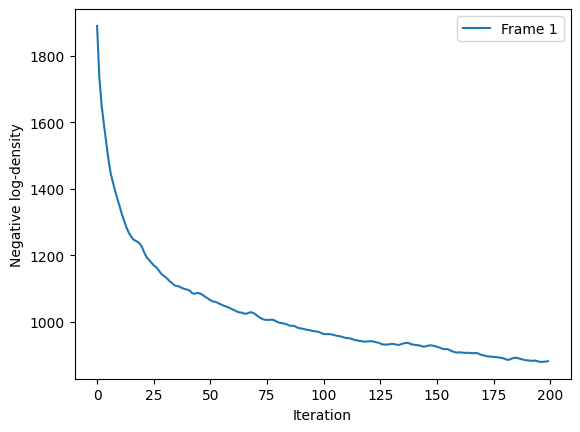

Average joint to joint distance - GBAOAB:  1086.733486076378
Average joint movement: 149.94807229723452


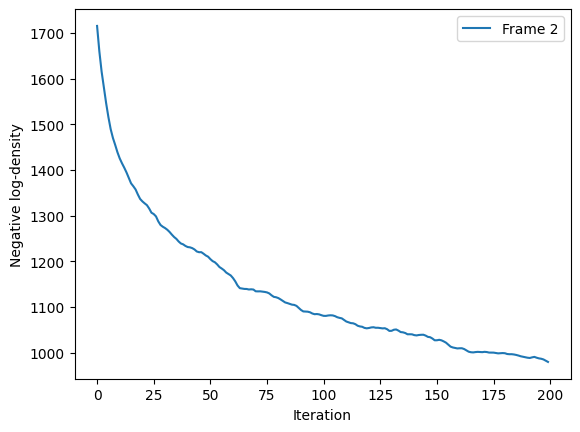

Average joint to joint distance - GBAOAB:  1206.86140105534
Average joint movement: 589.5841214073819


KeyboardInterrupt: ignored

In [135]:
plt.figure()
h = 1 # stepsize
std = 1 # standard deviation for the noise applied to the image.
i =0

diffs = []
diffs1 = []
diffs_bfgs = []
f = IntProgress(min=0, max=len(test_dataset[0:10]))
display(f)
for frame1 in test_dataset[0:10]:
    i +=1
    frame = torch.squeeze(frame1)
    M = torch.eye(39*3)

    # initialising from a random training pose
    x_init = torch.flatten(train_dataset[random.randint(0,len(train_dataset))-1])
    v_init = torch.zeros_like(x_init)


    # defining the constraints
    wrist_elbow_l = length_constraint(joints[1],joints[2],x_init)
    elbow_shoulder_l = length_constraint(joints[1],joints[7],x_init)
    wrist_elbow_r = length_constraint(joints[5],joints[4],x_init)
    elbow_shoulder_r= length_constraint(joints[4],joints[9],x_init)

    knee_ankle_l = length_constraint(joints[6],joints[10],x_init)
    knee_ankle_r = length_constraint(joints[8],joints[11],x_init)

    knee_asis_l = length_constraint(joints[6],joints[0],x_init)
    knee_asis_r = length_constraint(joints[8],joints[3],x_init)

    shoulder_clav_l = length_constraint(joints[13],joints[7],x_init)
    shoulder_clav_r = length_constraint(joints[13],joints[9],x_init)

    gs = [wrist_elbow_l,wrist_elbow_r,elbow_shoulder_l,elbow_shoulder_r,knee_ankle_l, knee_ankle_r,shoulder_clav_l,shoulder_clav_r, knee_asis_l, knee_asis_r]


    # defining and randomly perturbing the image
    fx = 1.0
    fy = 1.0
    cx = 0
    cy = 0
    a1 = torch.tensor([[fx], [0], [cx]], dtype=torch.double)
    a2 = torch.tensor([[0], [fy], [cy]], dtype=torch.double)
    a3 = torch.tensor([[0],[0],[1]], dtype=torch.double)
    i1 = frame @ a1
    i2 = frame @ a2
    i3 = frame @ a3
    image = torch.hstack([i1/i3, i2/i3])


    image += torch.randn_like(image)* std

    # define the negative log density, force and mass to use the new image
    def neg_log_density(pose2):
        pose = pose2.reshape((39,3))
        fx = 1.0
        fy = 1.0
        cx = 0
        cy = 0
        a1 = torch.tensor([[fx], [0], [cx]], dtype=torch.double)
        a2 = torch.tensor([[0], [fy], [cy]], dtype=torch.double)
        a3 = torch.tensor([[0],[0],[1]], dtype=torch.double)

        # Map the 3D point to 2D point
        p1 = pose@ a1
        p2 = pose @ a2
        p3 = pose @ a3

        projection = torch.hstack([p1/p3, p2/p3])

        n = projection - image

        # note - variance should be changed when changing the random perturbations
        pi = torch.tensor([0.], requires_grad=True)
        for point in n:
            pi = pi+ torch.linalg.norm(point)**2 / std

        p2 = torch.flatten(pose)
        for i in range(len(eigenvalues)):
            pi = pi+ (torch.dot(torch.tensor(eigenposes[i]),(p2-torch.tensor(avg_pose)))**2 / eigenvalues[i])
        return pi

    def force(x):
        return torch.squeeze(torch.tensor([1.])*jacobian(neg_log_density, x), dim = 0)

    # running g-baoab
    positions1, velocities1 = gBAOAB_integrator(x_init,v_init, force,gs, h,M, 10, 1, 200)

    # plotting the trajectory of the negative log density
    densities = [neg_log_density(p).detach().numpy() for p in positions1]
    plt.plot(densities, label = f"Frame {i}")
    plt.xlabel('Iteration')
    plt.ylabel('Negative log-density')
    plt.legend()
    plt.show()

    # getting the mean position
    mean1 =torch.tensor(np.array(torch.stack(positions1[50:])).mean(axis=0))

    jd1 = avg_j2j(mean1.reshape((39,3)),frame)
    print("Average joint to joint distance - GBAOAB: ", jd1)
    diffs1.append(jd1)

    print(f"Average joint movement: {mean1.mean()}")